In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
def output_to_accu(model, X, y):
    nb_errors = 0
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        _, predicted_classes = output.max(1)
        for k in range(1):
            if y[b + k, predicted_classes[k]] != 1.:
                nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / X.size(0))
    return accuracy

In [5]:
def output_to_loss(model, X, y):
    nb_errors = 0
    loss = 0
    criterion = nn.BCELoss()
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        loss += criterion(output, y.narrow(0, b, 1))
        
    return loss

In [6]:
indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', sheet_name='price', index_col=0, skiprows=[0,1,2,3,5,6,7])

In [7]:
bench_price = indices_price_excel['SPI Index'].asfreq('D', method='ffill')
price = indices_price_excel[indices_price_excel.columns[1:]].asfreq('D', method='ffill')
daily_returns = price.pct_change()
daily_return_bench = bench_price.pct_change()
price.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-04,426.47,2049.35,423.28,3395.8
1996-01-05,426.04,2054.88,424.38,3376.1
1996-01-06,426.04,2054.88,424.38,3376.1
1996-01-07,426.04,2054.88,424.38,3376.1
1996-01-08,427.94,2071.98,427.67,3368.1


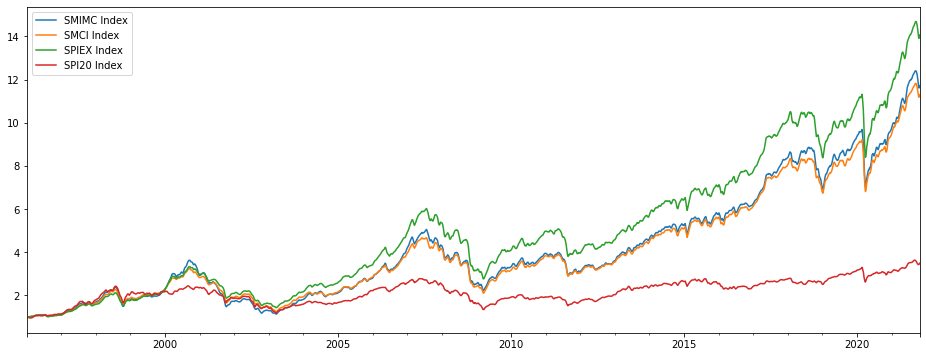

In [8]:
fig, ax = plt.subplots(figsize=(16,6))
(daily_returns + 1).cumprod().rolling(20).mean().plot(ax=ax)
plt.show()

In [9]:
mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

In [10]:
ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

In [11]:
def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [12]:
RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

In [13]:
df_dict = {}
df_X = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                         mom12[col], mom6[col], mom1[col],
                         vol12[col], vol6[col], vol1[col],
                         RSI14[col], RSI9[col], RSI3[col], 
                         MACD[col]], axis=1).asfreq('D', method='ffill').loc['1997-01-01':].fillna(method='ffill')
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'RSI3', 'MACD']
    df_dict[col] = df_temp
    
df_X = pd.concat(df_dict, axis=1)

In [14]:
df_X.head()

SMIMC Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.014890  0.028585  0.045367  0.010506  0.075344  0.019856   
1997-01-02    0.014115  0.027852  0.045311  0.011880  0.083172  0.006702   
1997-01-03    0.024387  0.038145  0.056274  0.017091  0.085253  0.024929   
1997-01-04    0.023670  0.037469  0.056143  0.017091  0.085253  0.024929   
1997-01-05    0.022953  0.036752  0.056000  0.017091  0.085253  0.024929   

                                                                               \
                vol12       vol6      vol1     RSI14      RSI9 RSI3      MACD   
1997-01-01  13.719565  10.620504  2.162347  0.615010  0.978405  1.0  6.190702   
1997-01-02  13.744065  10.594086  2.318069  0.832454  1.000000  1.0  6.350959   
1997-01-03  13.788874  10.691504  2.958671  0.898156  1.000000  1.0  7.231276   
1997-01-04  13.833463  10.779621  3.388369  0.898156  1.000000  1.0  7.884812   
1997-01-05  13.877834  10.858662  3.681764  0.898156  1.000000  1.0  8.354988   

           SMCI Index                                                    \
                 ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01   0.016542  0.028523  0.043469  0.022806  0.059253  0.018812   
1997-01-02   0.015814  0.027907  0.043290  0.025663  0.061989  0.012682   
1997-01-03   0.019494  0.031651  0.047446  0.020537  0.066345  0.020078   
1997-01-04   0.018922  0.031064  0.047253  0.020537  0.066345  0.020078   
1997-01-05   0.018351  0.030481  0.047059  0.020537  0.066345  0.020078   

                                                                            \
                vol12       vol6       vol1     RSI14 RSI9 RSI3       MACD   
1997-01-01  47.984405  41.541541  11.184891  0.904803  1.0  1.0  32.111086   
1997-01-02  48.278193  41.841704  11.879759  0.909276  1.0  1.0  32.591935   
1997-01-03  48.571762  42.273342  12.893541  0.912335  1.0  1.0  34.262517   
1997-01-04  48.862882  42.670494  13.479862  0.912335  1.0  1.0  35.380295   
1997-01-05  49.151597  43.034114  13.693742  0.912335  1.0  1.0  36.053943   

           SPIEX Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.012731  0.023844  0.035974  0.018865  0.051314  0.016044   
1997-01-02    0.012116  0.023314  0.035867  0.020046  0.053429  0.011041   
1997-01-03    0.012516  0.023703  0.036648  0.013051  0.052451  0.015167   
1997-01-04    0.012105  0.023237  0.036539  0.013051  0.052451  0.015167   
1997-01-05    0.011694  0.022772  0.036426  0.013051  0.052451  0.015167   

                                                                             \
               vol12      vol6      vol1     RSI14      RSI9 RSI3      MACD   
1997-01-01  8.783314  7.628690  1.956667  0.812865  0.849088  1.0  4.820640   
1997-01-02  8.826825  7.673586  2.164066  0.884224  1.000000  1.0  5.030273   
1997-01-03  8.860569  7.727818  2.300195  0.867540  1.000000  1.0  5.228772   
1997-01-04  8.894121  7.777260  2.380605  0.867540  1.000000  1.0  5.354686   
1997-01-05  8.927482  7.822003  2.410876  0.867540  1.000000  1.0  5.422408   

           SPI20 Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.015337  0.029673  0.050574  0.074637  0.067595  0.021931   
1997-01-02    0.014737  0.028939  0.050109  0.074725  0.070494  0.021295   
1997-01-03    0.013774  0.027773  0.049123  0.066044  0.080575  0.026255   
1997-01-04    0.013557  0.027146  0.048707  0.066044  0.080575  0.026255   
1997-01-05    0.013340  0.026511  0.048312  0.066044  0.080575  0.026255   

                                                                            \
                 vol12       vol6       vol1     RSI14      RSI9      RSI3   
1997-01-01  115.067084  87.412133  34.653116  0.781818  0.869

In [15]:
monthly_return = price.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)
best_pred = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 1., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred_one = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred_one.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1997-01-31,1.0,0.0,0.0,0.0
1997-02-28,0.0,0.0,0.0,1.0
1997-03-31,0.0,0.0,0.0,1.0
1997-04-30,1.0,0.0,0.0,0.0
1997-05-31,0.0,0.0,0.0,1.0


In [17]:
def pred_to_perf(df_pred, tax=0.):
    first_date = df_pred.index[0]
    last_date = df_pred.index[-1]
    daily_ret = daily_returns[first_date:last_date].asfreq('D', method='ffill')
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    df_perf = (df_pred_daily * daily_ret).sum(axis=1)
    df_cost = (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int) * tax
    return (1 + df_perf - df_cost).cumprod()

In [19]:
def price_to_perf(df):
    df = df.asfreq('D', method='ffill')
    return (1 + df.pct_change().fillna(0)).cumprod()

In [21]:
class MLP(nn.Module):
    def __init__(self, x1, x2, x3, pdrop=0.1):
        super().__init__()
        self.fc1 = nn.Linear(x1 * x2 * x3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)
        self.drop = nn.Dropout(pdrop)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu(self.drop(self.fc1(x)))
        x = self.relu(self.drop(self.fc2(x)))
        x = self.relu(self.drop(self.fc3(x)))
        x = self.fc4(x)
        x = self.sigmoid(x)
        
        return x

In [22]:
class ConvNet(nn.Module):
    def __init__(self, x1, x2, x3, pdrop=0.01):
        super().__init__()
        
        
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(2, 2, x3))
        # 16 x (x1 - 1) x (x2 - 1) x (x3 - (x3-1)) = 16 x 3 x 3 x 1
        
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(2, 2, 1))
        # 16 x (3 - 1) x (3 - 1) x 1 = 32 x 2 x 2
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 4)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(pdrop)
        self.drop2d = nn.Dropout2d(pdrop)

    def forward(self, x):
        
        x = x.view(x.size(0), 1, x.size(1), x.size(2), x.size(3))
    
        x = self.relu(self.drop2d(self.conv1(x)))
        x = self.relu(self.drop2d(self.conv2(x)))
        
        #print(x.shape)
        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [23]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_size=5, num_layers=2, dropout=0):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.randn(num_layers, x.size(0), hidden_size)
        c0 = torch.randn(num_layers, x.size(0), hidden_size)
        x = x.view(x.size(0), x.size(1), x.size(2) * x.size(3))
        x, _ = self.lstm(x, (h0, c0))
        x = self.relu(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))
        
        return x

In [39]:
def strategie(model='MLP', nb_epochs=50):
    
    first_end_date = '2002-01-01'
    input_period = 4
    num_tickers = 4
    num_features = 13
    
    # ML parameters
    pdrop=0.1
    eta = 1e-3
    mini_batch_size = 5
    
    # LSTM parameters
    hidden_size = 20
    num_layers = 5
    
    prob_output = []
    pred_output = []
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
    for i, end_date in enumerate(tqdm(all_end_dates)):
        # Data
        start_date = end_date - relativedelta(years=5)
        start_date_input = start_date.replace(day=1)    
        df_input = df_X.loc[start_date_input:end_date]
        df_output = best_pred_one.loc[start_date:end_date] # best_pred // best_pred_one

        X = []
        for idx in df_output.index:
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
            X_period = df_input_period.values.reshape(num_tickers, input_period, num_features).transpose(1,0,2)
            X.append(X_period)
        X = np.array(X)
        y = df_output.values

        if i == 0:
            #first_start_date_test = end_date.replace(day=31, month=1)
            first_start_date_test = end_date - relativedelta(months=5)

        # start_date_test = end_date.replace(day=31, month=1)
        start_date_test = end_date - relativedelta(months=5)
        split_index = df_output.index.get_loc(start_date_test)    
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]

        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

        train_mean = X_train.mean(dim=[0,1,2], keepdim=True)
        train_std = X_train.std(dim=[0,1,2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)

        #train_size = X_train.size(0)
        #shuffle_idx = torch.randperm(train_size)
        #X_train = X_train[shuffle_idx, :, :]
        #y_train = y_train[shuffle_idx, :]

        test_mean = X_test.mean(dim=[0,1,2], keepdim=True)
        test_std = X_test.std(dim=[0,1,2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)

        # Model
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if model == 'MLP':
            model = MLP(dim1, dim2, dim3, pdrop)
        elif model == 'CONVNET':
            model = ConvNet(dim1, dim2, dim3, pdrop)
        elif model == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, hidden_size=hidden_size, num_layers=num_layers)
            
        optimizer = torch.optim.Adam(model.parameters(), lr=eta)
        #optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
        criterion = nn.BCELoss()
        #criterion = nn.MSELoss()

        train_accu_list = []
        train_loss_list = []
        test_accu_list = []
        test_loss_list = []
        for e in range(nb_epochs):
            acc_loss = 0
            model.train()
            for b in range(0, X_train.size(0), mini_batch_size):
                optimizer.zero_grad()
                output = model(X_train.narrow(0, b, mini_batch_size))
                loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
                acc_loss = acc_loss + loss.item()
                loss.backward()
                optimizer.step()

            model.eval()
            train_accu = output_to_accu(model, X_train, y_train)
            train_accu_list.append(train_accu)
            test_accu = output_to_accu(model, X_test, y_test)
            test_accu_list.append(test_accu)

            train_loss = output_to_loss(model, X_train, y_train)
            train_loss_list.append(train_loss)
            test_loss = output_to_loss(model, X_test, y_test)
            test_loss_list.append(test_loss)

        #    if (e % 10) == 0:
        #        print('epoch', e + 1, ':', acc_loss)

        #fig = plt.figure(figsize=(12,6))
        #plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
        #plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
        #plt.show()
        #fig = plt.figure(figsize=(12,6))
        #plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
        #plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
        #plt.show()

        model.eval()
        pred = np.zeros((X_test.size(0), y_test.size(1)))
        for b in range(0, X_test.size(0)):
            output = model(X_test.narrow(0, b, 1))
            _, pred_index = output.max(1)
            pred[b, pred_index.item()] = 1
        prob_output.append(output)
        pred_output.append(pred)

    pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
    return df_pred, pred_output

In [41]:
models_list = ['MLP', 'CONVNET', 'LSTM']
df_pred_dict = {}
perf_pred_dict = {}
nb_epochs = 2
for model in models_list:
    df_pred_dict[model], _ = strategie(model, nb_epochs)
    perf_pred_dict[model] = pred_to_perf(df_pred_dict[model])

100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


In [46]:
end_date = df_pred_dict['MLP'].index[-1]
perf_bench = price_to_perf(bench_price.loc[first_start_date_test:end_date])

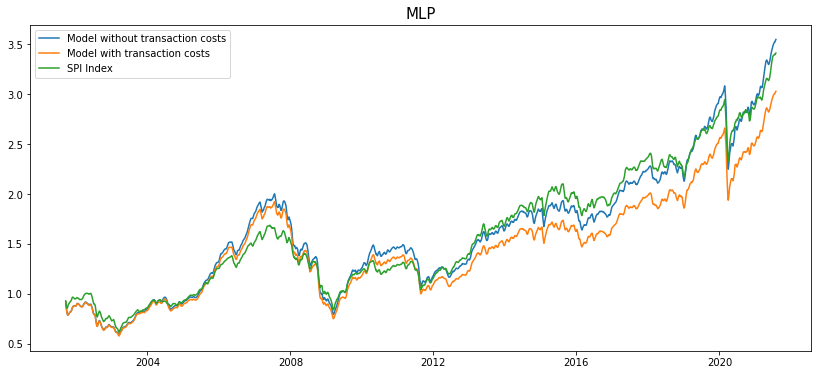

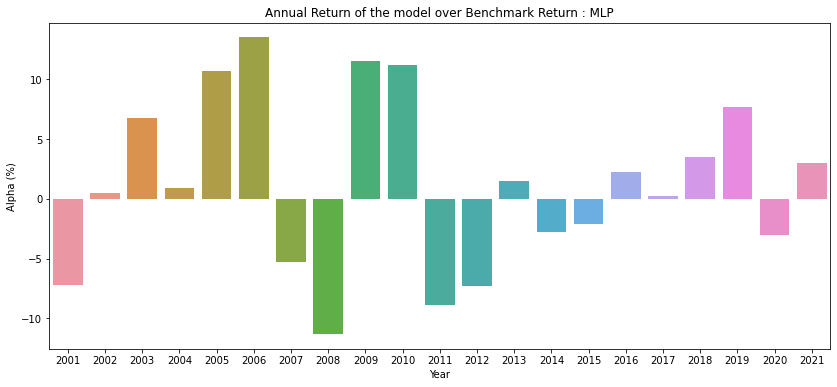

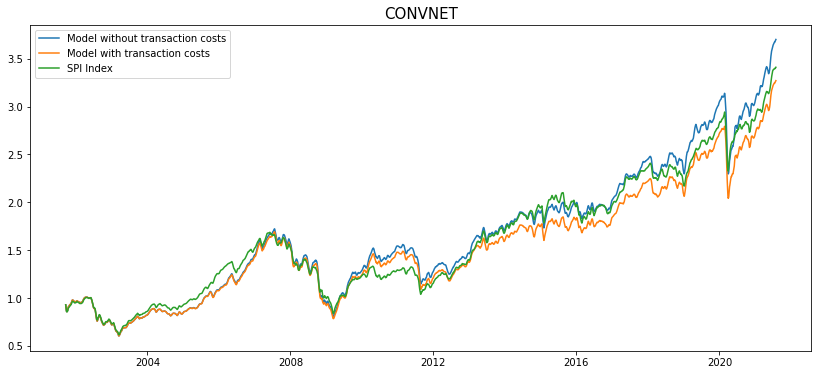

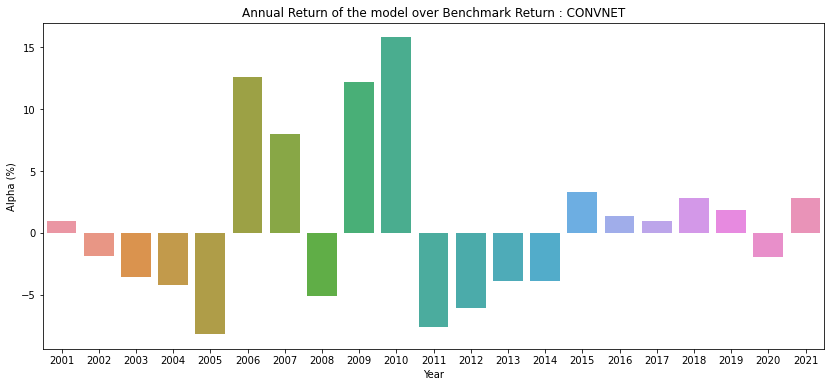

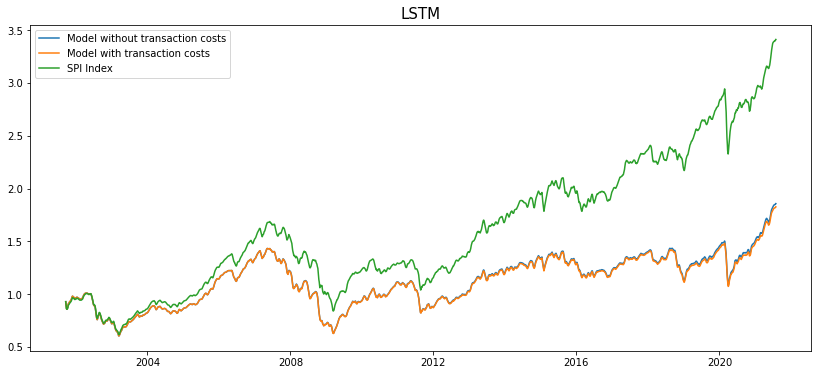

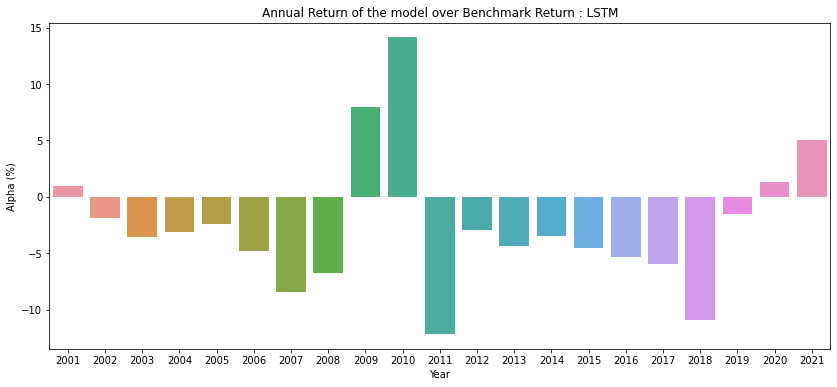

In [52]:
for model in models_list:
    performance_plot(df_pred_dict[model], model)
    annual_alpha_plot(perf_bench, perf_pred_dict[model], model)

In [100]:
bench_stats = perf_to_stat(perf_bench)
stats = []
stats.append(bench_stats + [0])
for model in models_list:
    turnover_num = turnover(df_pred_dict[model])
    stats.append(perf_to_stat(perf_pred_dict[model]) + [turnover(df_pred_dict[model])])
stats = np.array(stats)
df_stats = pd.DataFrame(data=stats, columns=['Avg. annual return', 'Avg. annual vol.', 'Avg Sharpe ratio', 'Max. Drawdown', 'Turnover'], index=['Benchmark SPI']+models_list).round(2)
df_stats

,Avg. annual return,Avg. annual vol.,Avg Sharpe ratio,Max. Drawdown,Turnover
Benchmark SPI,7.59,8.86,0.86,40.91,0.0
MLP,8.80,10.64,0.83,45.68,132.0
CONVNET,8.37,9.97,0.84,45.60,103.0
LSTM,5.07,7.10,0.71,42.31,14.0


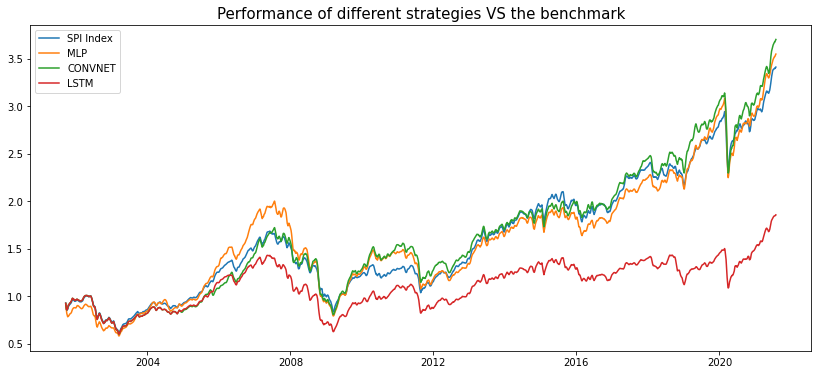

In [110]:
data = pd.DataFrame(perf_bench)
for model in models_list:
    data = pd.concat([data, perf_pred_dict[model].rename(model)], axis=1)

fig = plt.figure(figsize=(14,6))
plt.title('Performance of different strategies VS the benchmark', fontsize=15)
sns.lineplot(data=data.rolling(20).mean(), dashes=False)
plt.show()

In [58]:
def turnover(df_pred):
    daily_ret = daily_returns[first_start_date_test:end_date].asfreq('D', method='ffill')
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    return (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int).sum().sum()

In [60]:
def perf_to_stat(perf):
    year_group = perf.resample('Y')
    average_year_return = ((year_group.last() - year_group.first()) / year_group.first()).mean() * 100
    average_year_std = year_group.std().mean() * 100
    average_year_sharpe = average_year_return / average_year_std
    
    dd_window = 252
    roll_max = perf.rolling(dd_window).max()
    daily_dd = perf / roll_max - 1
    max_daily_dd = np.abs(daily_dd.rolling(dd_window, min_periods=1).min()).max() * 100

    return [average_year_return, average_year_std, average_year_sharpe, max_daily_dd]

In [50]:
def performance_plot(df_pred, model):
    perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
    perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')

    data = pd.concat([perf_pred_gross, perf_pred_net, price_to_perf(bench_price[first_start_date_test:end_date])], axis=1)

    fig = plt.figure(figsize=(14,6))
    plt.title(model, fontsize=15)
    sns.lineplot(data=data.rolling(20).mean(), dashes=False)
    plt.show()

In [51]:
def annual_alpha_plot(perf_bench, perf_pred, model):
    year_group_bench = perf_bench.resample('Y')
    year_group_pred = perf_pred.resample('Y')
    annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
    annual_returns_pred = (year_group_pred.last() - year_group_pred.first()) / year_group_pred.first()
    annual_diff = (annual_returns_pred - annual_returns_bench) * 100
    df_annual_diff = pd.DataFrame(columns=['year', 'alpha'])
    df_annual_diff['year'] = annual_diff.index.year
    df_annual_diff['alpha'] = annual_diff.values

    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(data=df_annual_diff, x='year', y='alpha')
    plt.ylabel('Alpha (%)')
    plt.xlabel('Year')
    plt.title('Annual Return of the model over Benchmark Return : ' + model)
    plt.show()

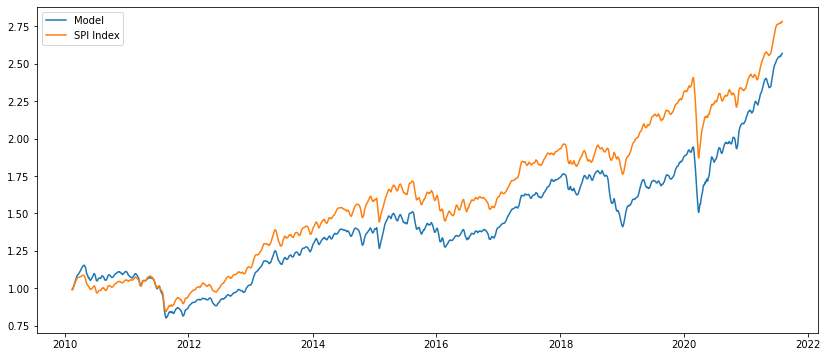

In [722]:
fig = plt.figure(figsize=(14,6))
start_date_plot = '2010-01-31'
perf_pred = pred_to_perf(df_pred[start_date_plot:]).rename('Model')
perf_bench = price_to_perf(bench_price.loc[start_date_plot:end_date])
data = pd.concat([perf_pred, perf_bench], axis=1)
                 
sns.lineplot(data=data.rolling(15).mean(), dashes=False)
plt.show()

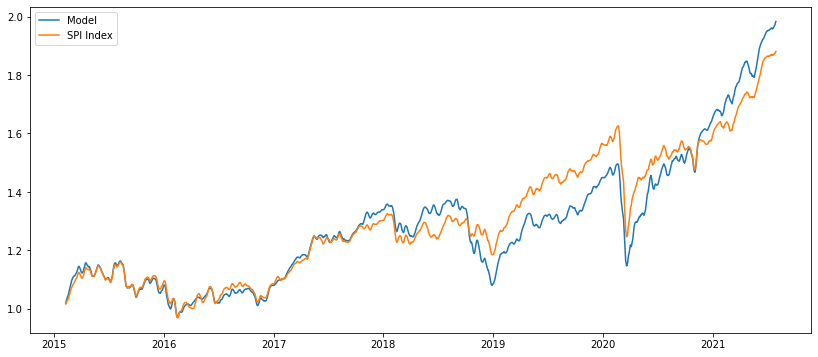

In [723]:
fig = plt.figure(figsize=(14,6))
start_date_plot = '2015-01-31'
perf_pred = pred_to_perf(df_pred[start_date_plot:]).rename('Model')
data = pd.concat([perf_pred, price_to_perf(bench_price.loc[start_date_plot:end_date])], axis=1)
                 
sns.lineplot(data=data.rolling(10).mean(), dashes=False)
plt.show()

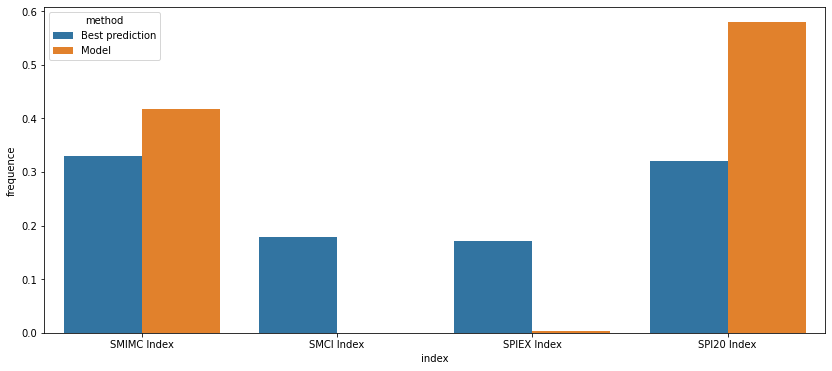

In [754]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_pred_test_one.sum(axis=0) / len(best_pred_test_one), df_pred.sum(axis=0) / len(best_pred_test_one)], axis=1).rename(columns={0:'Best prediction', 1:'Model'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='index', y='frequence', hue='method')
plt.show()

In [29]:
first_end_date = '2002-01-01'
input_period = 4
num_tickers = 4
num_features = 13
pdrop=0.1
eta = 1e-3
mini_batch_size = 5

hidden_size = 20
num_layers = 5

nb_epochs = 50

prob_output = []
pred_output = []
all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
for i, end_date in enumerate(all_end_dates):
    print(end_date)
    # Data
    start_date = end_date - relativedelta(years=5)
    start_date_input = start_date.replace(day=1)    
    df_input = df_X.loc[start_date_input:end_date]
    df_output = best_pred_one.loc[start_date:end_date] # best_pred // best_pred_one
    
    X = []
    for idx in df_output.index:
        df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        X_period = df_input_period.values.reshape(num_tickers, input_period, num_features).transpose(1,0,2)
        X.append(X_period)
    X = np.array(X)
    y = df_output.values
    
    if i == 0:
        #first_start_date_test = end_date.replace(day=31, month=1)
        first_start_date_test = end_date - relativedelta(months=5)
     
    # start_date_test = end_date.replace(day=31, month=1)
    start_date_test = end_date - relativedelta(months=5)
    split_index = df_output.index.get_loc(start_date_test)    
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    train_mean = X_train.mean(dim=[0,1,2], keepdim=True)
    train_std = X_train.std(dim=[0,1,2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)
    
    #print(df_output[split_index:])   
    
    #train_size = X_train.size(0)
    #shuffle_idx = torch.randperm(train_size)
    #X_train = X_train[shuffle_idx, :, :]
    #y_train = y_train[shuffle_idx, :]
                      
    test_mean = X_test.mean(dim=[0,1,2], keepdim=True)
    test_std = X_test.std(dim=[0,1,2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)
    
    # Model
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    model = MLP(dim1, dim2, dim3, pdrop)
    # model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, hidden_size=hidden_size, num_layers=num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
    criterion = nn.BCELoss()
    #criterion = nn.MSELoss()
    
    train_accu_list = []
    train_loss_list = []
    test_accu_list = []
    test_loss_list = []
    for e in range(nb_epochs):
        acc_loss = 0
        model.train()
        for b in range(0, X_train.size(0), mini_batch_size):
            optimizer.zero_grad()
            output = model(X_train.narrow(0, b, mini_batch_size))
            loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()
            loss.backward()
            optimizer.step()
            
        model.eval()
        train_accu = output_to_accu(model, X_train, y_train)
        train_accu_list.append(train_accu)
        test_accu = output_to_accu(model, X_test, y_test)
        test_accu_list.append(test_accu)

        train_loss = output_to_loss(model, X_train, y_train)
        train_loss_list.append(train_loss)
        test_loss = output_to_loss(model, X_test, y_test)
        test_loss_list.append(test_loss)

        if (e % 10) == 0:
            print('epoch', e + 1, ':', acc_loss)
            
    #fig = plt.figure(figsize=(12,6))
    #plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
    #plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
    #plt.show()
    #fig = plt.figure(figsize=(12,6))
    #plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
    #plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
    #plt.show()
    
    model.eval()
    pred = np.zeros((X_test.size(0), y_test.size(1)))
    for b in range(0, X_test.size(0)):
        output = model(X_test.narrow(0, b, 1))
        _, pred_index = output.max(1)
        pred[b, pred_index.item()] = 1
    prob_output.append(output)
    pred_output.append(pred)
    
pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred_test.index, data=pred_output, columns=best_pred.columns)

2002-01-31 00:00:00
epoch 1 : 7.665142238140106
epoch 6 : 5.2926792204380035
epoch 11 : 3.9509102553129196
epoch 16 : 2.5049044750630856
epoch 21 : 1.177216051146388
epoch 26 : 0.9344437243416905
epoch 31 : 0.9532850761897862
epoch 36 : 0.37936623441055417
epoch 41 : 0.17561351921176538
epoch 46 : 0.12714407341991318
epoch 51 : 0.2966369988862425
epoch 56 : 0.12754987291555153
epoch 61 : 0.04189102213058504
epoch 66 : 0.03947610397167978
epoch 71 : 0.01997273268563049
epoch 76 : 0.06380552697510211
epoch 81 : 0.03365571218091645
epoch 86 : 0.016831080163228762
epoch 91 : 0.04713951206576894
epoch 96 : 0.01208073375528329
epoch 101 : 0.02607519188745755
epoch 106 : 0.006446624850241278
epoch 111 : 0.003298901692318168
epoch 116 : 0.005039253258019016
epoch 121 : 0.0024255238853356786
epoch 126 : 0.019030329334782436
epoch 131 : 0.005730611796025187
epoch 136 : 0.005193393116769585
epoch 141 : 0.008209874320982635
epoch 146 : 0.009658134420305942
epoch 151 : 0.003907733222376919
epoch 15

epoch 81 : 0.018362639559200034
epoch 86 : 0.04729081360710552
epoch 91 : 0.37365657939517405
epoch 96 : 0.6268550457898527
epoch 101 : 0.12144010624615476
epoch 106 : 0.047887066306429915
epoch 111 : 0.025116217395407148
epoch 116 : 0.013351024244911969
epoch 121 : 0.010785183262669307
epoch 126 : 0.0105860511357605
epoch 131 : 0.017537978885229677
epoch 136 : 0.01027751099991292
epoch 141 : 0.00647438312171289
epoch 146 : 0.005981867904438332
epoch 151 : 0.0022662119244216683
epoch 156 : 0.0019232045306125656
epoch 161 : 0.031542360893581645
epoch 166 : 0.005988440673718287
epoch 171 : 0.0023648815595151973
epoch 176 : 0.017835752897553903
epoch 181 : 0.0030855769336994854
epoch 186 : 0.002068571473500924
epoch 191 : 0.004248545399832437
epoch 196 : 0.0018200121487552678
2005-07-31 00:00:00
epoch 1 : 7.303268492221832
epoch 6 : 5.388395190238953
epoch 11 : 4.33280012011528
epoch 16 : 2.8870714977383614
epoch 21 : 1.5924481935799122
epoch 26 : 0.9568519070744514
epoch 31 : 0.384036863

epoch 161 : 0.02564122336480068
epoch 166 : 0.016147931273735594
epoch 171 : 0.00362162232022456
epoch 176 : 0.0022882889415996033
epoch 181 : 0.0013038494139436807
epoch 186 : 0.009987892836306855
epoch 191 : 0.004052217915159417
epoch 196 : 0.004341945834312355
2008-07-31 00:00:00
epoch 1 : 7.309955537319183
epoch 6 : 5.280414372682571
epoch 11 : 3.8707634657621384
epoch 16 : 2.4165761172771454
epoch 21 : 1.2807265371084213
epoch 26 : 0.5907583143562078
epoch 31 : 0.33439904637634754
epoch 36 : 0.14831909956410527
epoch 41 : 0.11254631564952433
epoch 46 : 0.12235732149565592
epoch 51 : 0.055025519483024254
epoch 56 : 0.047154630097793415
epoch 61 : 0.06360386626329273
epoch 66 : 0.16329245193628594
epoch 71 : 0.04281917866319418
epoch 76 : 0.06666619989846367
epoch 81 : 0.018990535754710436
epoch 86 : 0.03566349911125144
epoch 91 : 0.011916322546312585
epoch 96 : 0.018641473863681313
epoch 101 : 0.008158111977536464
epoch 106 : 0.012069734104443341
epoch 111 : 0.011862844388815574
ep

KeyboardInterrupt: 

In [663]:
X_train.shape

torch.Size([55, 4, 4, 13])

In [664]:
dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
model = ConvNet(dim1, dim2, dim3, 0.2)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()

eta = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
mini_batch_size = 1
nb_epochs = 100

train_accu_list = []
test_accu_list = []

train_loss_list = []
test_loss_list =[]
for e in range(nb_epochs):
    
    acc_loss = 0
    
    
    for b in range(0, X_train.size(0), mini_batch_size):
        optimizer.zero_grad()
        
        output = model(X_train.narrow(0, b, mini_batch_size))
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        loss.backward()
        
        optimizer.step()
    
    
    if (e % 2) == 0:
        print('epoch', e + 1, ':', acc_loss)

epoch 1 : 37.69046300649643
epoch 3 : 35.70568561553955
epoch 5 : 33.19234263896942
epoch 7 : 30.461486786603928
epoch 9 : 26.618535347282887
epoch 11 : 23.308599578216672
epoch 13 : 20.730907682329416
epoch 15 : 16.309789199382067
epoch 17 : 11.553497355547734
epoch 19 : 8.60691264576326
epoch 21 : 5.467502064944711
epoch 23 : 7.530251419986598
epoch 25 : 5.524844269280038
epoch 27 : 3.0316515504091512
epoch 29 : 1.8036937879078323
epoch 31 : 2.4838610283622984
epoch 33 : 2.394421721342951
epoch 35 : 0.643574305337097
epoch 37 : 0.8401377755255908
epoch 39 : 0.7990523069524897
epoch 41 : 0.6164810997749157
epoch 43 : 1.5280483075039228
epoch 45 : 0.5212842680857648
epoch 47 : 0.3056151452249196
epoch 49 : 0.4334928653237
epoch 51 : 0.2976828504880018
epoch 53 : 0.21041655920508617
epoch 55 : 0.09164673455369154
epoch 57 : 0.11873761103578317
epoch 59 : 0.08584198222797568
epoch 61 : 0.26008424930846274
epoch 63 : 0.258602489259971
epoch 65 : 0.42533075888374583
epoch 67 : 0.1696321388

In [99]:
print('X shape', np.shape(X))
print('y shape', np.shape(y))

X shape (71, 4, 13, 4)
y shape (71, 4)


In [101]:
X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

train_mean = X_train.mean(dim=[0,1,3], keepdim=True)
train_std = X_train.std(dim=[0,1,3], keepdim=True)
X_train = X_train.sub_(train_mean).div_(train_std)

test_mean = X_test.mean(dim=[0,1,3], keepdim=True)
test_std = X_test.std(dim=[0,1,3], keepdim=True)
X_test = X_test.sub_(test_mean).div_(test_std)



In [102]:
X_train.shape

torch.Size([50, 4, 13, 4])

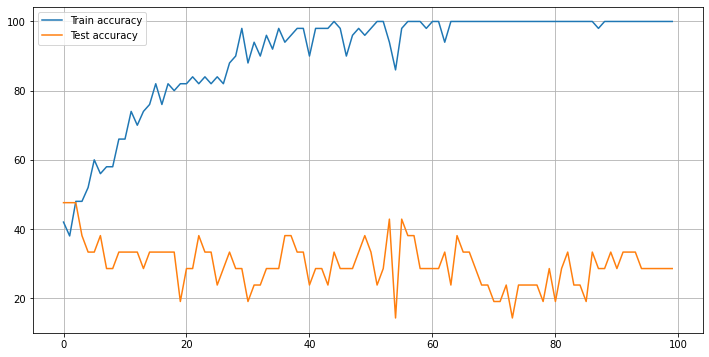

In [135]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()

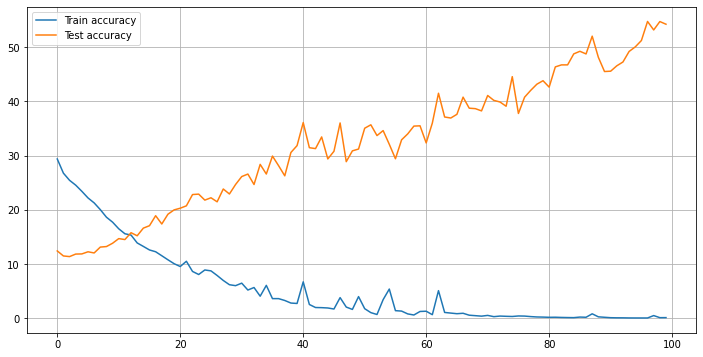

In [136]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_loss_list, label='Train accuracy')
plt.plot(list(range(nb_epochs)), test_loss_list, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()

In [126]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_train = np.zeros((X_train.size(0), y_train.size(1)))
model.eval()

for b in range(0, X_train.size(0), mini_batch_size):
    output = model(X_train.narrow(0, b, mini_batch_size))
    output_list.append(output)
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_train[b, predicted_classes[k]] = 1
        if y_train[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
    
print('accuracy on train set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_train.size(0)))

accuracy on train set: 100.00%


In [131]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_test = np.zeros((X_test.size(0), y_test.size(1)))
prediction_rank = []
model.eval()

for b in range(0, X_test.size(0), mini_batch_size):
    output = model(X_test.narrow(0, b, mini_batch_size))
    output_list.append(output)
    prediction_rank.append(np.array(torch.sort(output)[1]).reshape(-1))
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_test[b, predicted_classes[k]] = 1
        if y_test[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
prediction_rank = np.array(prediction_rank)
print('accuracy on test set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_test.size(0)))

accuracy on test set: 28.57%


In [134]:
fig = plt.figure(figsize=(14,6))
df_pred = pd.DataFrame(data=prediction_test, columns=price.columns, index=best_pred[split_index:].index)
split_date = str(best_pred.iloc[split_index].name)
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_convnet)], axis=1).rename(columns={0:'Best prediction', 1:'ConvNet'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(bench_price[split_date:])], axis=1))
plt.show()

ValueError: Shape of passed values is (21, 4), indices imply (247, 4)

<Figure size 1008x432 with 0 Axes>

In [261]:
growth_rate = 0.0003
daily_vol = 0.01
mean = (pd.DataFrame(data=np.ones(len(bench_price)), index=bench_price.index, columns=['mean']) + growth_rate).cumprod()
mean

,mean
1996-01-04,1.000300
1996-01-05,1.000600
1996-01-08,1.000900
1996-01-09,1.001201
1996-01-10,1.001501
...,...
2021-10-19,7.526253
2021-10-20,7.528510
2021-10-21,7.530769
2021-10-22,7.533028


In [273]:
vol_forecasted = pd.DataFrame(index=bench_price.index)
vol_forecasted['vol'] = daily_vol
vol_forecasted.reset_index(inplace=True, drop=True)
vol_forecasted['t'] = vol_forecasted.index + 1
vol_forecasted['cumul_vol'] = vol_forecasted.vol * np.sqrt(vol_forecasted.t)
vol_forecasted.index = mean.index
vol_forecasted

,vol,t,cumul_vol
1996-01-04,0.01,1,0.010000
1996-01-05,0.01,2,0.014142
1996-01-08,0.01,3,0.017321
1996-01-09,0.01,4,0.020000
1996-01-10,0.01,5,0.022361
...,...,...,...
2021-10-19,0.01,6729,0.820305
2021-10-20,0.01,6730,0.820366
2021-10-21,0.01,6731,0.820427
2021-10-22,0.01,6732,0.820488


In [274]:
mean['upper'] = mean['mean'] + 2 * vol_forecasted.cumul_vol
mean['lower'] = mean['mean'] - 2 * vol_forecasted.cumul_vol

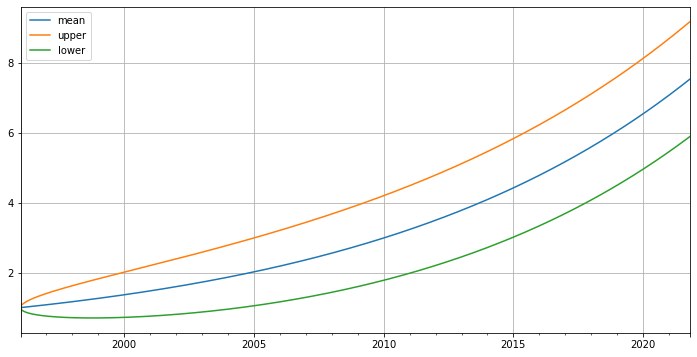

In [311]:
fig, ax = plt.subplots(figsize=(12,6))
mean.plot(ax=ax)
plt.grid()
plt.show()

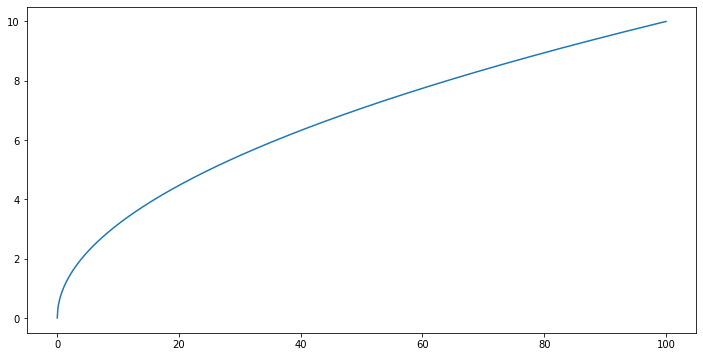

In [281]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0,100,1000)
plt.plot(x, np.sqrt(x))
plt.show()